<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/FPGrowth01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FP-Growth Algorithm

The FP-growth algorithm is an efficient divide-and-conquer frequent pattern mining technique. 
Unlike more basic algorithms such a Apriori, FP-growth does not generate large candidate sets for every possible frequent itemset. 
Instead of scanning the entire database multiple times, it compresses the database into a frequent pattern tree, which retains the itemset association information. 
It transforms the problem of finding long frequent patterns into searching for shorter patterns in smaller conditional databases recursively, then concatenating the suffix.

## Objectives
1. To implement the FP-Growth algorithm and test it under different configurations
2. To mine maximal patterns
3. To mine association rules from the frequent patterns
4. To perform a sensitivity analysis on the minimum support threshold



The dataset contains retail market basket data from an anonymous Belgian retail store. 
The retail dataset was originally used in the following paper: paper link. 
Each line in the .txt file shows the items purchased in one transaction (transaction IDs are not provided), and items are separated by a space.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import math
from itertools import combinations
import time

dataset_name =   'data/retail.txt'       # the dataset name (such as dataset.txt)
patterns_path =  'output/patterns.csv'   # the file name that will store the frequent patterns
rules_path =     'output/rules.csv'      # the file name that will store the association rules
maximal_path =   'output/maximal.csv'    # the file name that will store the maximal patterns
min_support =     0.0015          # minimuum support threshold in percentage format (for example 0.2 means 20%)
min_confidence =  0.9             # the minimum confidence threshold in the percentage format

In [2]:
# populate the transactions tidlist
with open(dataset_name) as f:
    tid_list = [tuple(map(str, i.strip().split(' '))) for i in f]

## Implement the FP-Growth Algorithm

I will implement the FP-Growth algorithm, using the following algorithm. 
Then, I will display the total execution time, the total number of generated candidates, and the total number of frequent patterns. 
Each line will contain one pattern, its support count, and support. 
For example, the pattern A-B-C with support count 4 and support 0.5 will be saved in one line as {A, B, C},4,0.5 in the patterns.csv file.
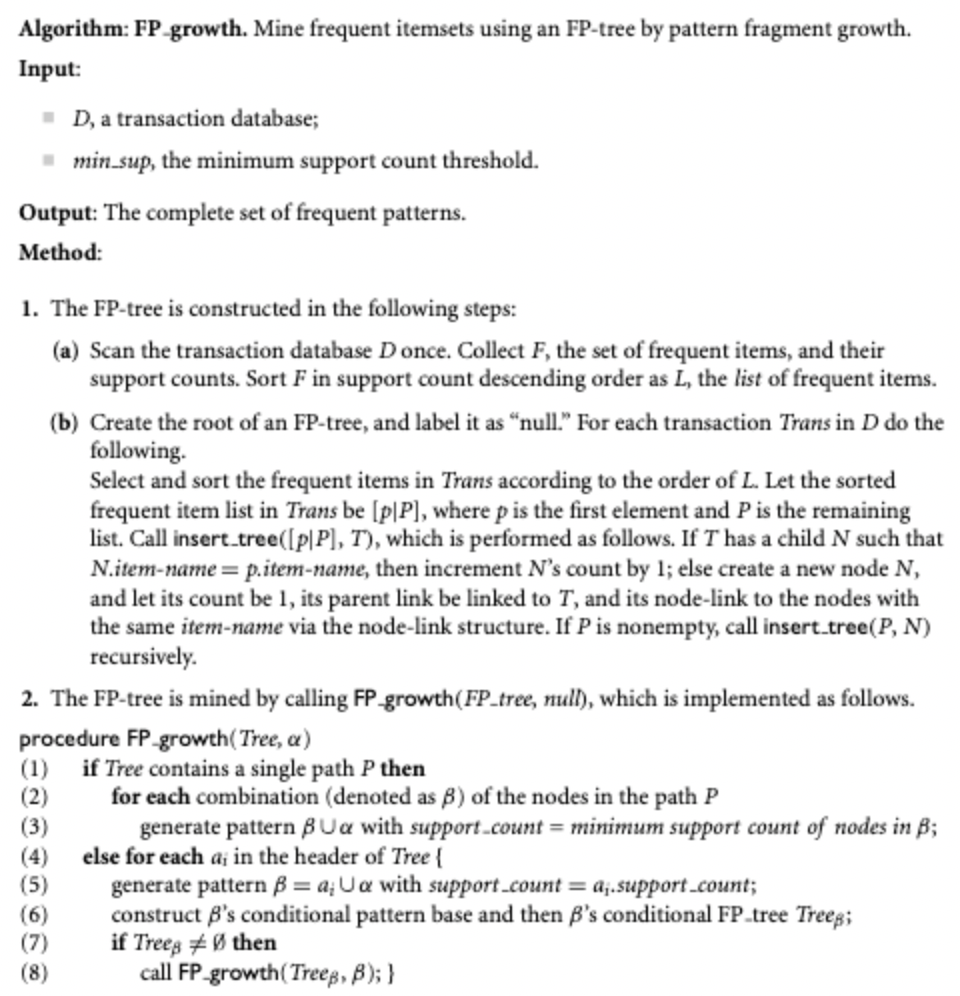

In [3]:
import itertools

# builds and mines an FP-tree
class FP:  
    def __init__(self, tid_list, min_sup, num_transactions=None):
        self._min_sup = min_sup
        self._num_transactions = num_transactions
        
        self._header_table = []
        self._tree = [[pd.NA, pd.NA, pd.NA, [], pd.NA]]
        self._freq_patterns = []
        
        if self._num_transactions is None:
            self._num_transactions = len(tid_list)
            
        self.build(tid_list)
    
    @property
    def tree(self):
        return pd.DataFrame(self._tree, columns=['item', 'count', 'parent', 'children', 'node_link'])
    
    @property
    def header_table(self):
        return self._header_table
    
    @property
    def freq_patterns(self):
        return pd.DataFrame(self._freq_patterns, columns=['pattern', 'count', 'support'])
    
    # traverses linked nodes until the tail is reached, returns the index of the tail
    def traverse_link(self, start_node):
        curr_node = start_node
        
        # traverse the node-link until end is reached
        next_node = self._tree[curr_node][4]
        tail = None
        
        if next_node is not pd.NA:
            tail = self.traverse_link(next_node)
        else: 
            tail = curr_node
            
        return tail
        
    # adds a new linked node for an item listed on the header table
    def add_link(self, item, new_node_index):
        
        # find the item's index in the header table
        item_index = self._header_table.index[self._header_table['item'] == item][0]
        
        # get the head to the item's node-link
        head = self._header_table.loc[item_index, 'node_link']
        
        # if no head exists, set the new node as the head
        if head is pd.NA:
            self._header_table.loc[item_index, 'node_link'] = new_node_index
            
        # else, traverse the node-link until the end is reached, then link the new node
        else:
            # get the tail
            tail = self.traverse_link(head)
            # link the new node to the tail
            self._tree[tail][4] = new_node_index
    
    # inserts a list of items into an FP tree
    def insert(self, items, root_index=0):
        if len(items) == 0:
            return
        
        root = self._tree[root_index]
        children = root[3]
        p = items[0]
        matching_prefix = False
        next_node = None

        # for each root child, determine whether child[item] == p
        for child_index in children:
            child = self._tree[child_index]
            child_item = child[0]

            # if child_item == p, increment child[count] and stop checking
            if child_item == p:
                self._tree[child_index][1] += 1 # increment child[count]
                matching_prefix = True
                next_node = child_index # traverse down this node next
                break

        # if no children match with p, create a new root child and let its count be 1
        if not matching_prefix:
            # create a new child
            new_child = [p, 1, root_index, [], pd.NA]
            
            # add the new child to the tree
            self._tree.append(new_child)
            
            # get the new child's index
            new_child_index = len(self._tree) - 1
            
            # add the child to the root's children list
            self._tree[root_index][3].append(new_child_index)
            
            # add the child to linked nodes
            self.add_link(p, new_child_index)
            
            # set the new child as the next node to traverse
            next_node = new_child_index

        # get the remaining items after p
        remaining_items = items[1:]

        # if remaining_items not empty, call insert_tree recursively
        if len(remaining_items) > 0:
            self.insert(remaining_items, next_node)

    # builds the FP-tree and header table
    def build(self, tid_list):
    
        # get the support count for each 1-itemset in tid_list
        item_sup_counts = {}
        for transaction in tid_list:
            for item in transaction:
                item_sup_counts[item] = item_sup_counts.get(item, 0) + 1

        # determine whether each 1-item set meets the minimum support
        freq_item_sup = []
        for item, sup_count in item_sup_counts.items():
            sup = sup_count / self._num_transactions
            
            # if the item meets the min_sup, add the item and its count to the freq_items list
            if sup >= self._min_sup:
                freq_item_sup.append([item, sup_count])

        # sort and store freq_items in support descending order
        freq_item_sup.sort(reverse=True, key=lambda x: x[1])
        freq_items_sup = np.array(freq_item_sup)
        
        # create the header table
        freq_items, counts, node_links = [], [], []
        
        if freq_items_sup.size > 0:
            freq_items = freq_items_sup[:, 0]
            counts = freq_items_sup[:, 1]
            node_links = [pd.NA] * len(freq_items)
            
        self._header_table = pd.DataFrame({'item': freq_items, 'count': counts, 'node_link': node_links})

        # insert frequent transaction items into FP-tree
        for transaction in tid_list:
            # select the frequent items in the transaction
            freq_trans_items = [item for item in transaction if item in freq_items]

            # sort the frequent items in descending support order
            freq_trans_items.sort(key=lambda x: np.where(freq_items == x)[0])

            # insert the transaction into fp_tree
            self.insert(freq_trans_items)
        
    # returns a node's prefix pattern as a list
    def get_prefix_pat(self, start_node):
        prefix_pat = []
        curr_node = start_node
        next_node = self._tree[curr_node][2] # curr_node's parent
        
        # keep traversing up the parent nodes and stop when the next node is the root node
        while next_node != 0:
            # traverse up to parent node
            curr_node = next_node
            
            # get the node's item
            item = self._tree[curr_node][0]
            
            # add the item to the beggining of prefix_pat
            prefix_pat.insert(0, item)
            
            next_node = self._tree[curr_node][2] # curr_node's parent
            
        return prefix_pat
    
    # mines the FP-tree for frequent patterns
    def grow(self, suffix_pattern=set()):
        
        # if the tree contains a single path, generate a frequent pattern for each combination of nodes in the path
        if all(len(children) <= 1 for children in self.tree['children']):
            
            # get the path nodes
            path_nodes = self.tree.loc[1:, :].index.tolist()
            
            # generate all subset combinations of path nodes 
            for L in range(1, len(path_nodes)+1):
                for subset in itertools.combinations(path_nodes, L):
                    
                    # get the subset of nodes
                    subset_nodes = self.tree.loc[subset, :]
                    
                    # get the subset items
                    subset_items = subset_nodes['item'].tolist()

                    # get the min support count of the nodes in the subset
                    min_count = subset_nodes['count'].min()
                    
                    # get the normalized support
                    support = min_count / self._num_transactions

                    # concatenate the subset items with suffix pattern to generate frequent pattern
                    freq_pattern = suffix_pattern.union(subset_items)

                    # save frequent pattern and its corresponding support
                    self._freq_patterns.append([freq_pattern, min_count, support])
            
            return
        
        # else, for each item in the header table, generate the conditional pattern base and conditional FP-tree, then mine the tree

        # reverse the header table
        header_table_rev = self._header_table.iloc[::-1]
        
        # construct each frequent 1-itemset's conditional pattern base and conditional FP-tree
        for index in header_table_rev.index:
            
            # get the item's node-link head
            head = header_table_rev.loc[index, 'node_link']
            
            # traverse the item's node link, adding each node's prefix pattern to the item's conditional pattern base
            cond_pat_base = []
            curr_node = head
            while curr_node is not pd.NA:
                
                # get the node's count
                count = self._tree[curr_node][1]
                
                # get the node's prefix pattern
                prefix_pat = self.get_prefix_pat(curr_node)
                
                # add prefix_pat to cond_pat_base once for each time the node is counted
                if len(prefix_pat) > 0:
                    for i in range(count):
                        cond_pat_base.append(prefix_pat)
                
                # move on to next node in link
                curr_node = self._tree[curr_node][4]

            # get the name of the item
            item_name = header_table_rev.loc[index, 'item']
            
            # get the item's support count
            item_count = int(header_table_rev.loc[index, 'count'])

            # generate frequent pattern by concatenating item to the suffix pattern
            freq_pattern = suffix_pattern.union({item_name})
            
            # save frequent pattern with corresponding support
            support = item_count / self._num_transactions
            self._freq_patterns.append([freq_pattern, item_count, support])
            
            # construct conditional FP-tree
            cond_fp = FP(cond_pat_base, self._min_sup, self._num_transactions)

            # mine conditional FP-tree
            cond_fp.grow(freq_pattern)

            # get frequent patterns mined from conditional FP-tree and corresponding supports
            freq_patterns = cond_fp._freq_patterns

            # save frequent patterns and supports
            self._freq_patterns += freq_patterns

In [4]:
# run FP-growth on the data

start_time = time.perf_counter()

fp = FP(tid_list, min_support)
fp.grow()

end_time = time.perf_counter()
cpu_time = end_time - start_time

In [5]:
print("Execution time: " + str(cpu_time) + " seconds") 
print("Frequent itemsets: " + str(len(fp._freq_patterns)))

Execution time: 305.5721758569998 seconds
Frequent itemsets: 4237


To facilitate tree traversal, an item header table is built so that each item points to its occurrences in the tree via a chain of node-links. 
In this way, the problem of mining frequent patterns in databases is transformed into that of mining the FP-tree.

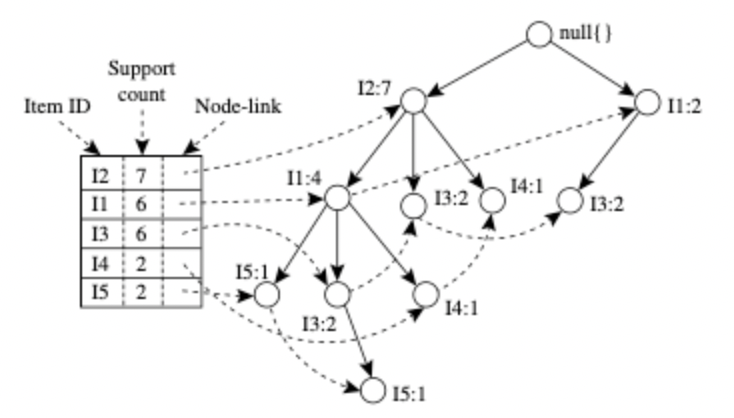

In [6]:
fp.header_table

,item,count,node_link
0,39,50675,20
1,48,42135,29
2,38,15596,21
3,32,15167,17
4,41,14945,22
...,...,...,...
1345,4056,133,5303
1346,4920,133,7951
1347,4996,133,8263
1348,5048,133,8473


In [7]:
fp.tree

,item,count,parent,children,node_link
0,<NA>,<NA>,<NA>,"[1, 17, 20, 45, 51, 62, 64, 86, 101, 145, 148,...",<NA>
1,9,110,0,"[2, 527, 7814, 8040, 16924, 19677, 27442, 2776...",526
2,19,4,1,"[3, 75791, 104467, 206227]",515
3,18,1,2,[4],227
4,23,1,3,[5],308
...,...,...,...,...,...
351466,1994,1,351465,[351467],<NA>
351467,695,1,351466,[351468],<NA>
351468,2830,1,351467,[351469],<NA>
351469,393,1,351468,[],<NA>


In [8]:
# save the frequent patterns to csv
fp.freq_patterns.to_csv(patterns_path, index=False)
fp.freq_patterns

,pattern,count,support
0,{5465},133,0.001509
1,{5048},133,0.001509
2,{4996},133,0.001509
3,{4920},133,0.001509
4,{4056},133,0.001509
...,...,...,...
4232,"{48, 39, 38}",6102,0.069213
4233,"{39, 38}",10345,0.117341
4234,{48},42135,0.477927
4235,"{48, 39}",29142,0.330551


## Find Maximal Itemsets

Next, I will find the maximal itemset among all the generated frequent patterns. 
An itemset X is a maximal frequent itemset (or max-itemset) in a data set D if X is frequent, and there exists no super-itemset Y such that X ⊂ Y and Y is frequent in D. 
As before, each line in the maximal.csv output file will contain one pattern, its support count, and support.

In [9]:
freq_patterns = fp._freq_patterns

# sort the frequent itemsets in longest to shortest order
freq_patterns.sort(reverse=True, key=lambda x: len(x[0]))

# determine if each itemset is a subset of a discovered maximal intemset
max_itemsets = []
for i in freq_patterns:
    itemset = i[0]
    is_max = True
    
    # compare the itemset with each discovered maximal itemset
    for j in max_itemsets:
        max_itemset = j[0]
        
        # if itemset is a subset of a discovered maximal itemset, it cannot be a maximal itemset
        if itemset.issubset(max_itemset):
            is_max = False
            break
        
    # if the itemset is not a subset of any discovered maximal itemset, add it to the maximal itemsets
    if is_max:
        max_itemsets.append(i)

# save the maximal itemsets to csv
max_itemsets = pd.DataFrame(max_itemsets, columns=['pattern', 'count', 'support'])
max_itemsets.to_csv(maximal_path, index=False)
max_itemsets

,pattern,count,support
0,"{48, 16010, 41, 39, 16011}",133,0.001509
1,"{48, 38, 41, 39, 37}",151,0.001713
2,"{32, 48, 41, 39, 310}",133,0.001509
3,"{32, 48, 38, 110, 39}",201,0.002280
4,"{48, 38, 110, 41, 39}",346,0.003925
...,...,...,...
2050,{3553},232,0.002632
2051,{98},232,0.002632
2052,{2990},233,0.002643
2053,{4170},236,0.002677


In [10]:
num_freq_patterns = len(freq_patterns)
num_max_patterns = len(max_itemsets)
comp_ratio = (num_freq_patterns - num_max_patterns) / num_freq_patterns * 100

print("Frequent itemsets: " + str(num_freq_patterns))
print("Max patterns: " + str(num_max_patterns))
print("Compression ratio: " + str(comp_ratio) + "%")

Frequent itemsets: 4237
Max patterns: 2055
Compression ratio: 51.498701911729995%


## Mine the Association Rules
Now, I will implement association rule mining to generate strong association rules from the frequent itemsets generated using the below algorithm. 
Then, I will display the confidence for the top 20 rules with the highest confidence.

Each line in the rules.csv file will contain one rule alongside its support count, support, and confidence. 
For example, {A,}=>C,4,0.5,0.2 shows the support count, support, and confidence for the rule {A, B}=>C.

In [11]:
freq_patterns = fp.freq_patterns
association_rules = []

start_time = time.perf_counter()

# for each frequent itemset, generate all nonempty subsets
for index, row in freq_patterns.iterrows():
    itemset = row['pattern']
    itemset_count = row['count']
    itemset_sup = row['support']
    
    # generate the itemset's nonempty subsets
    for L in range(1, len(itemset)):
        for subset in itertools.combinations(itemset, L):
            subset = set(subset)
            
            # find the table row corresponding to the subset
            subset_row = freq_patterns[freq_patterns['pattern'] == subset]
            
            # get the subset's support count
            subset_count = subset_row.iloc[0, 1]
            
            # get the confidence for the rule "subset => (itemset - subset)"
            conf = itemset_count / subset_count
            
            # generate the rule
            rule = str(subset) + " => " + str(itemset - subset)
            
            # save the rule
            association_rules.append([rule, itemset_count, itemset_sup, conf])
            
end_time = time.perf_counter()
cpu_time = end_time - start_time
            
association_rules = pd.DataFrame(association_rules, columns=['rule', 'count', 'support', 'confidence'])
association_rules.sort_values(by=['confidence'], ascending=False, inplace=True)
association_rules.to_csv(rules_path, index=False)

# display the top 20 rules
association_rules.head(20)

,rule,count,support,confidence
819,"{'41', '48', '37'} => {'38'}",172,0.001951,1.000000
805,"{'32', '39', '37'} => {'38'}",137,0.001554,1.000000
58,"{'41', '48', '39', '37'} => {'38'}",151,0.001713,1.000000
2261,"{'170', '89', '48'} => {'38'}",140,0.001588,1.000000
148,"{'41', '48', '39', '110'} => {'38'}",346,0.003925,0.997118
650,"{'371', '48', '39'} => {'38'}",294,0.003335,0.996610
525,"{'48', '39', '105'} => {'38'}",290,0.003289,0.996564
5696,"{'41', '37'} => {'38'}",246,0.002790,0.995951
847,"{'41', '39', '37'} => {'38'}",202,0.002291,0.995074
117,"{'32', '39', '48', '110'} => {'38'}",201,0.002280,0.995050


In [12]:
# generate the strong rules
strong_rules = association_rules[association_rules['confidence'] >= min_confidence]
num_strong_rules = len(strong_rules.index)

print("Execution time: " + str(cpu_time) + " seconds")
print("Strong rules: " + str(num_strong_rules))

i = 1
for index, row in strong_rules.iterrows():
    rule = row['rule']
    conf = row['confidence']
    print("Rule " + str(i) + ": " + str(rule) + ", " + "conf = " + str(conf))
    i += 1

Execution time: 11.890010392999102 seconds
Strong rules: 156
Rule 1: {'41', '48', '37'} => {'38'}, conf = 1.0
Rule 2: {'32', '39', '37'} => {'38'}, conf = 1.0
Rule 3: {'41', '48', '39', '37'} => {'38'}, conf = 1.0
Rule 4: {'170', '89', '48'} => {'38'}, conf = 1.0
Rule 5: {'41', '48', '39', '110'} => {'38'}, conf = 0.9971181556195965
Rule 6: {'371', '48', '39'} => {'38'}, conf = 0.9966101694915255
Rule 7: {'48', '39', '105'} => {'38'}, conf = 0.9965635738831615
Rule 8: {'41', '37'} => {'38'}, conf = 0.9959514170040485
Rule 9: {'41', '39', '37'} => {'38'}, conf = 0.9950738916256158
Rule 10: {'32', '39', '48', '110'} => {'38'}, conf = 0.995049504950495
Rule 11: {'32', '37'} => {'38'}, conf = 0.9946236559139785
Rule 12: {'48', '16431'} => {'16430'}, conf = 0.9942857142857143
Rule 13: {'48', '39', '110'} => {'38'}, conf = 0.9942140790742526
Rule 14: {'371', '41'} => {'38'}, conf = 0.9941860465116279
Rule 15: {'41', '39', '790'} => {'38'}, conf = 0.9935064935064936
Rule 16: {'32', '39', '286

## Sensitivity Analysis
Finally, I will run the frequent pattern mining function with the following values of minimum support and measure the total number of frequent patterns and generated candidates and the execution time. 
Then, I will draw three line plots using the matplotlib library that shows how minimum support (the x-axis) affects the runtime and the number of candidates and frequent itemsets (the y-axis).

Minimum support values:

0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01

In [13]:
min_sups = (0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 
            0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01)
runtimes = []
nums_freq_itemsets = []

for min_sup in min_sups:
    
    start_time = time.perf_counter()
    
    fp = FP(tid_list, min_sup)
    fp.grow()
    
    end_time = time.perf_counter()
    cpu_time = end_time - start_time
    
    num_freq_itemsets = len(fp._freq_patterns)
    
    runtimes.append(cpu_time)
    nums_freq_itemsets.append(num_freq_itemsets)

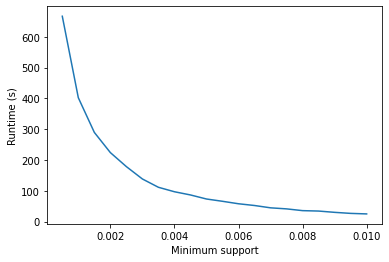

In [14]:
plt.plot(min_sups, runtimes)
plt.xlabel("Minimum support")
plt.ylabel("Runtime (s)")
plt.show()

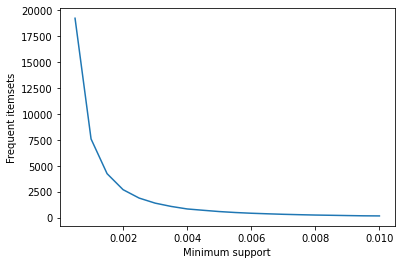

In [15]:
plt.plot(min_sups, nums_freq_itemsets)
plt.xlabel("Minimum support")
plt.ylabel("Frequent itemsets")
plt.show()